# MANDATORY ASSIGNMENT 1: LOGISTIC REGRESSION PROBLEM
## Problem: Givet bilens specifikationer, klassificer om den er fuel-efficient

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 2. Load Data

In [102]:
df = pd.read_csv("data/cars.csv")

# 3. Data Cleaning (samme som regression)


In [103]:
df['horsepower'] = df['horsepower'].replace('?', np.nan)
df['horsepower'] = pd.to_numeric(df['horsepower'])

target = "mpg"
features = ["cylinders", "displacement", "horsepower", "weight",
            "acceleration", "model year", "origin"]

df_clean = df[features + [target]].dropna().copy()

# 4. Create Binary Target Variable


In [38]:
# Vi bruger medianen til at definere om bilerne er "fuel-efficient"
median_mpg = df_clean[target].median()
print(f"\nMedian MPG: {median_mpg:.1f}")

# Opret binær målvariabel: 1 hvis mpg > median, 0 ellers
df_clean['is_efficient'] = (df_clean[target] > median_mpg).astype(int)

print(f"\nAntal fuel-efficient biler (mpg > {median_mpg:.1f}): {df_clean['is_efficient'].sum()}")
print(f"Antal ikke fuel-efficient biler: {len(df_clean) - df_clean['is_efficient'].sum()}")


Median MPG: 22.8

Antal fuel-efficient biler (mpg > 22.8): 196
Antal ikke fuel-efficient biler: 196


# 5. Prepare Features and Target


In [39]:
X = df_clean[features]
y = df_clean['is_efficient']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 313 samples
Test set: 79 samples


# 5.1 Feature Scaling

In [157]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling: FØR -> EFTER")
print(f"Weight: {X_train.iloc[0]['weight']:.0f} -> {X_train_scaled[0][3]:.2f}")


Feature scaling: FØR -> EFTER
Weight: 3620 -> 0.75


# 6. Train Logistic Regression Model


In [158]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
)

grid_search.fit(X_train_scaled, y_train)
log_reg = grid_search.best_estimator_

print(f"\nBedste C: {grid_search.best_params_['C']}")
print(f"CV accuracy: {grid_search.best_score_:.4f}")


Bedste C: 0.01
CV accuracy: 0.9171


# 7. Make Predictions


In [146]:
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print(f"\nPredictions: {sum(y_pred)}/{len(y_pred)} efficient ({sum(y_pred)/len(y_pred)*100:.1f}%)")
print(f"Confidence: avg={y_pred_proba.mean():.3f}, min={y_pred_proba.min():.3f}, max={y_pred_proba.max():.3f}")

examples = pd.DataFrame({
    'Actual': y_test.head(5).values,
    'Predicted': y_pred[:5],
    'Prob': y_pred_proba[:5],
    '': ['OK' if a == p else 'X' for a, p in zip(y_test.head(5).values, y_pred[:5])]
})
print("\n", examples.to_string(index=False))


Predictions: 45/79 efficient (57.0%)
Confidence: avg=0.514, min=0.028, max=0.889

  Actual  Predicted     Prob   
      1          1 0.729777 OK
      0          1 0.674426  X
      1          1 0.871926 OK
      1          1 0.694406 OK
      1          1 0.710912 OK


# 8. Evaluate Model


In [161]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print(f"\nAccuracy:  {accuracy:.3f} ({tp+tn}/{len(y_test)} korrekte)")
print(f"Precision: {precision:.3f} (af {tp+fp} 'efficient', {tp} var korrekte)")
print(f"Recall:    {recall:.3f} (fandt {tp} af {tp+fn} efficient biler)")
print(f"F1-score:  {f1:.3f}")


Confusion Matrix: TP=36, TN=33, FP=9, FN=1

Accuracy:  0.873 (69/79 korrekte)
Precision: 0.800 (af 45 'efficient', 36 var korrekte)
Recall:    0.973 (fandt 36 af 37 efficient biler)
F1-score:  0.878


# 8.1 Confusion Matrix Visualisering

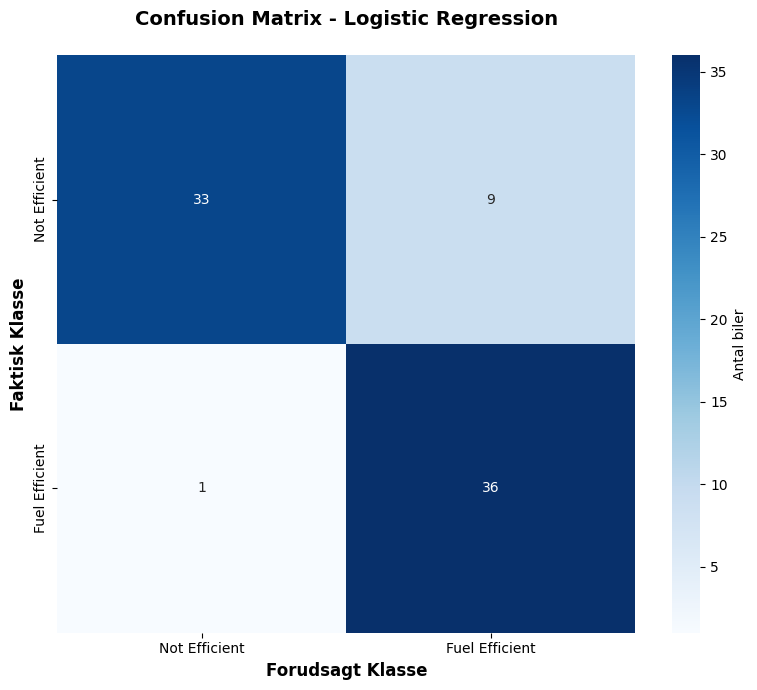


Confusion Matrix viser:
69 korrekte predictions ud af 79 (87.3%)
10 fejl (12.7%)


In [96]:
import seaborn as sns

# Visualiser confusion matrix
plt.figure(figsize=(8, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Efficient', 'Fuel Efficient'],
            yticklabels=['Not Efficient', 'Fuel Efficient'],
            cbar_kws={'label': 'Antal biler'})

plt.title('Confusion Matrix - Logistic Regression\n', fontsize=14, fontweight='bold')
plt.ylabel('Faktisk Klasse', fontsize=12, fontweight='bold')
plt.xlabel('Forudsagt Klasse', fontsize=12, fontweight='bold')

plt.tight_layout()  # Flyttet tight_layout() FØR plt.text()
plt.show()

print("\nConfusion Matrix viser:")
print(f"{tn + tp} korrekte predictions ud af {len(y_test)} ({accuracy*100:.1f}%)")
print(f"{fp + fn} fejl ({(fp+fn)/len(y_test)*100:.1f}%)")

# 8.2 ROC Curve og AUC Score


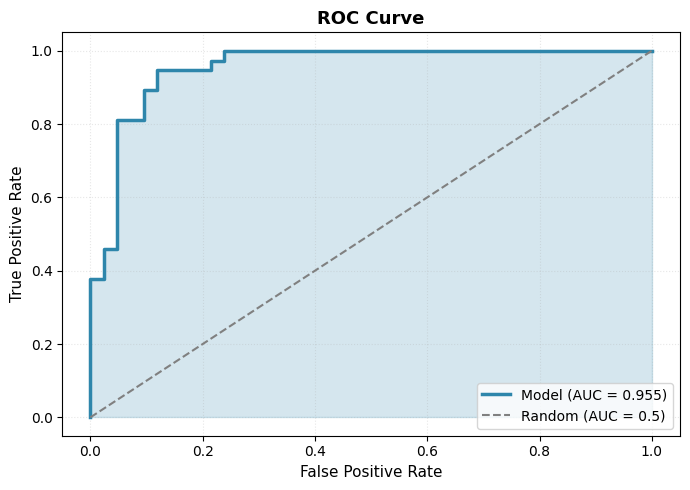

AUC Score: 0.955


In [152]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='#2E86AB', lw=2.5, label=f'Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.2, color='#2E86AB')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve', fontsize=13, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

# 9. Model Validation - Sammenligning med Træningsdata


In [159]:
y_train_pred = log_reg.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"\nTræning Accuracy: {train_accuracy:.3f} ({train_accuracy*100:.1f}%)")
print(f"Test Accuracy:    {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Forskel:          {abs(train_accuracy - accuracy):.3f} ({abs(train_accuracy - accuracy)*100:.1f}%)")

if abs(train_accuracy - accuracy) < 0.05:
    print("God generalisering - modellen overfitter ikke")


Træning Accuracy: 0.917 (91.7%)
Test Accuracy:    0.873 (87.3%)
Forskel:          0.044 (4.4%)
God generalisering - modellen overfitter ikke


# 10. Feature Importance (Coefficients)


In [153]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', ascending=False)

print(feature_importance.to_string(index=False))
print("\nPositive koefficienter øger sandsynligheden for fuel-efficient")
print("Negative koefficienter mindsker sandsynligheden for fuel-efficient")

     Feature  Coefficient
  model year     0.272619
      origin     0.219132
acceleration     0.074588
  horsepower    -0.266026
displacement    -0.320244
   cylinders    -0.332859
      weight    -0.357700

Positive koefficienter øger sandsynligheden for fuel-efficient
Negative koefficienter mindsker sandsynligheden for fuel-efficient
